##### ФИО: Дубровный Николай Андреевич

In [1]:
## Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection,ensemble,linear_model,metrics
import math
%matplotlib inline

In [2]:
## Загружаем данные в DataFrame
data = pd.read_csv('data_devim.csv', sep=';')

In [3]:
## Посмотрим как выглядит наш DataFrame
data.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
0,143822.0,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,2017-07-23,0.0,728319,320464,1
1,0.0,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,2017-07-23,0.0,728321,320466,1
2,51356.0,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,2017-07-23,0.0,728323,320467,1
3,0.0,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,2017-07-23,0.0,728447,320533,1
4,12298.0,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,2017-07-23,0.0,728421,298598,1


In [4]:
## Посмотрим общую информацию
data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   closed_cred_sum          50001 non-null  float64
 1   closed_creds             50001 non-null  int64  
 2   active_cred_sum_overdue  50001 non-null  float64
 3   active_cred_sum          50001 non-null  float64
 4   active_cred_day_overdue  50001 non-null  int64  
 5   active_cred_max_overdue  50001 non-null  float64
 6   age                      50001 non-null  int64  
 7   gender                   50001 non-null  int64  
 8   region                   50001 non-null  int64  
 9   first_loan               49982 non-null  float64
 10  loan_cost_all            50001 non-null  int64  
 11  first_days_quant         50001 non-null  int64  
 12  month_income             50001 non-null  float64
 13  order_date               50001 non-null  object 
 14  cost_all              

Большинство объектов представленно в формате float или int - числовые признаки  
Один признак - категориальный (order_date) - это дата подачи заявки  
пропущенные значения есть только у одного признака (first_loan) желаемая сумма для получения

In [5]:
## преобразуем формат даты в datetime
data.order_date = pd.to_datetime(data.order_date)

In [6]:
## Сразу посмотрим на дату первой и последней заявки
print (data.order_date.min())
print (data.order_date.max())

2017-06-26 00:00:00
2017-09-25 00:00:00


In [7]:
## Видим, что данные предоставлены за 4 месяца 2017 года
## Отсортируем DataFrame в порядке возрастания даты
data = data.sort_values(by = 'order_date').reset_index(drop = True)

In [8]:
## В задании указано, что метка 0 соответствует классу (одобрено)
## а метка 1 - отказано
## поменяем метки местами для более привычного восприятия
mapping = {1:0,0:1}
data.expert.replace(mapping, inplace = True)

In [9]:
## Посмотрим на количество уникальных значений
data.nunique()

closed_cred_sum            25314
closed_creds                 166
active_cred_sum_overdue    20189
active_cred_sum            25138
active_cred_day_overdue     4719
active_cred_max_overdue    21721
age                           68
gender                         2
region                        99
first_loan                    69
loan_cost_all                117
first_days_quant              39
month_income                 247
order_date                    80
cost_all                    2561
order_id                   42857
client_id                  40159
expert                         2
dtype: int64

In [10]:
## Видим, что количество клиентов меньше, чем количество объектов,
## поэтому проверим нет ли дубликатов в нашем DataFrame
data.duplicated()[data.duplicated() == True]

168      True
323      True
394      True
400      True
404      True
         ... 
49993    True
49996    True
49998    True
49999    True
50000    True
Length: 7058, dtype: bool

In [11]:
## 7058 дубликатов нашли, удалим дубликаты
data.drop_duplicates(inplace = True)

Количество клиентов по-прежнему меньше, чем количество объектов - значит, что некоторые клиенты несколько раз подавали заявку на кредит

In [13]:
## Еще раз посмотрим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42943 entries, 0 to 49997
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   closed_cred_sum          42943 non-null  float64       
 1   closed_creds             42943 non-null  int64         
 2   active_cred_sum_overdue  42943 non-null  float64       
 3   active_cred_sum          42943 non-null  float64       
 4   active_cred_day_overdue  42943 non-null  int64         
 5   active_cred_max_overdue  42943 non-null  float64       
 6   age                      42943 non-null  int64         
 7   gender                   42943 non-null  int64         
 8   region                   42943 non-null  int64         
 9   first_loan               42926 non-null  float64       
 10  loan_cost_all            42943 non-null  int64         
 11  first_days_quant         42943 non-null  int64         
 12  month_income             42943 n

In [14]:
## Переиндексируем DataFrame
data = data.reset_index(drop = True)

In [15]:
## Заметим, что количество строк больше, чем количество уникальных заявок
## Отберем номера заявок, которые встречаются больше 1 раза
order_numbers = data.groupby('order_id')['client_id'].count().sort_values(ascending=False)[
            data.groupby('order_id')['client_id'].count().sort_values(ascending=False)>1].reset_index()['order_id'].values
print (order_numbers)

[699736 826660 754277 752370 744191 752401 744976 749765 757155 751601
 757998 748832 743215 758171 759041 747027 827110 827129 744226 710321
 839607 748198 755645 757511 759391 744759 757845 744382 744380 700600
 717220 748145 725759 755455 717208 739151 748692 725692 827209 749630
 745117 828630 711946 758770 752757 750991 830428 747596 756756 828858
 745118 719967 828999 754843 756625 829690 752911 829141 756512 831073
 756861 753108 747830 758963 831968 745835 827563 827570 747156 758323
 753197 752619 827858 747211 827874 756400 828034 746574 829456 757613
 748424 748338 718890 755725 840280 742694]


In [16]:
## Отберем индексы повторяющихся заявок
repeat_order_index = data.isin(order_numbers)[data.isin(order_numbers).order_id].index.values
print (repeat_order_index)

[ 2657  2658  2824  2825  9629  9630  9790  9791 13362 13363 13411 13412
 14317 14325 15711 15712 18794 18795 18796 18797 26331 26332 29249 29250
 29846 29847 29915 29924 29925 29926 30124 30126 30509 30510 30768 30783
 31056 31057 31341 31343 31344 31358 31477 31478 31970 31971 32052 32067
 32157 32383 32581 32582 32818 32819 32834 32835 32935 32936 32982 32983
 33040 33055 33217 33218 33490 33491 33754 33755 34710 34718 34757 34764
 35167 35168 35656 35701 35999 36004 36094 36095 36147 36148 36229 36230
 36236 36237 36706 36707 37051 37052 37173 37180 38430 38436 38536 38548
 38911 38912 39037 39038 39239 39240 39249 39250 39411 39412 39453 39454
 39619 39620 39804 39805 39910 39928 40133 40134 40581 40582 40605 40606
 40736 40737 40889 40890 41176 41177 41346 41347 41436 41437 41475 41476
 41877 41878 41896 41905 41962 41963 42004 42008 42009 42022 42024 42036
 42038 42043 42067 42105 42106 42107 42118 42119 42139 42140 42153 42154
 42164 42176 42191 42217 42250 42251 42317 42326 42

In [216]:
## Посмотрим на повторяющиеся заявки
data_repeat_order = data.iloc[data.isin(order_numbers)[data.isin(order_numbers).order_id].index.values]
data_repeat_order.head(50)

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
2641,1166889.00,35,30932.64,208000.00,377,30932.64,41,0,0,7000.0,6000,7,30000.0,2017-06-29,6915.6,700600,154353,1
2806,284608.15,24,0.00,95500.00,0,0.00,30,0,0,8000.0,5500,7,50000.0,2017-06-29,0.0,699736,305642,1
9576,226574.40,13,0.00,11000.00,0,0.00,30,0,3,4000.0,4000,10,45000.0,2017-07-07,4872.0,710321,277780,1
9736,74338.00,5,12837.37,50997.30,706,8000.00,39,1,65,5000.0,5000,10,25000.0,2017-07-08,0.0,711946,189876,0
13287,59000.00,7,0.00,688873.48,0,0.00,45,1,59,9000.0,2000,10,60000.0,2017-07-13,2436.0,717220,315040,1
13335,29104.00,4,3000.00,27000.00,3,3000.00,31,1,3,7000.0,7000,20,50000.0,2017-07-13,0.0,717208,315031,0
14244,103000.00,8,0.00,19000.00,0,0.00,30,0,0,7000.0,7000,10,60000.0,2017-07-14,0.0,718890,315911,0
15626,6500.00,5,0.00,1500.00,0,0.00,25,0,36,5000.0,5000,90,0.0,2017-07-16,0.0,719967,316421,0
18690,22500.00,7,0.00,3000.00,0,0.00,36,0,80,10000.0,10000,21,0.0,2017-07-21,0.0,725692,319143,0
18691,22500.00,7,0.00,3000.00,0,0.00,36,0,80,5000.0,5000,21,0.0,2017-07-21,0.0,725759,319143,0


Наблюдаем, что некоторые заявки встречаются дважды  
Такое могло произойти, если сначала создали заявку с ошибкой, а потом ее исправили и создали новую заявку, но предыдущую не удалили  
Но в данной ситуации трудно понять какая из заявок правильная, так как ошибки встречаются совершенно разные, поэтому возьмём по одной из повторяющихся заявок.

In [22]:
## Удалим повторяющиеся заявки
data = data.drop_duplicates(subset='order_id', keep='last').reset_index(drop = True)

In [25]:
## Снова проверим пропущенные значения
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42857 entries, 0 to 42856
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   closed_cred_sum          42857 non-null  float64       
 1   closed_creds             42857 non-null  int64         
 2   active_cred_sum_overdue  42857 non-null  float64       
 3   active_cred_sum          42857 non-null  float64       
 4   active_cred_day_overdue  42857 non-null  int64         
 5   active_cred_max_overdue  42857 non-null  float64       
 6   age                      42857 non-null  int64         
 7   gender                   42857 non-null  int64         
 8   region                   42857 non-null  int64         
 9   first_loan               42840 non-null  float64       
 10  loan_cost_all            42857 non-null  int64         
 11  first_days_quant         42857 non-null  int64         
 12  month_income             42857 n

In [27]:
## Совсем мало пропущенных значений осталось
## Можно не использовать строки с пропущенными значениями
data = data.dropna().reset_index(drop = True)

In [29]:
## Напишем функцию, чтобы строить графики boxplot
def boxplot(df,columns,subplot_height,subplot_width = 3):
    i = 1
    plt.figure(figsize = (20,10))
    for column in columns:
        ax = plt.subplot(subplot_height,subplot_width,i)
        ax.set_title(column)
        ax.boxplot(df[column])
        i += 1

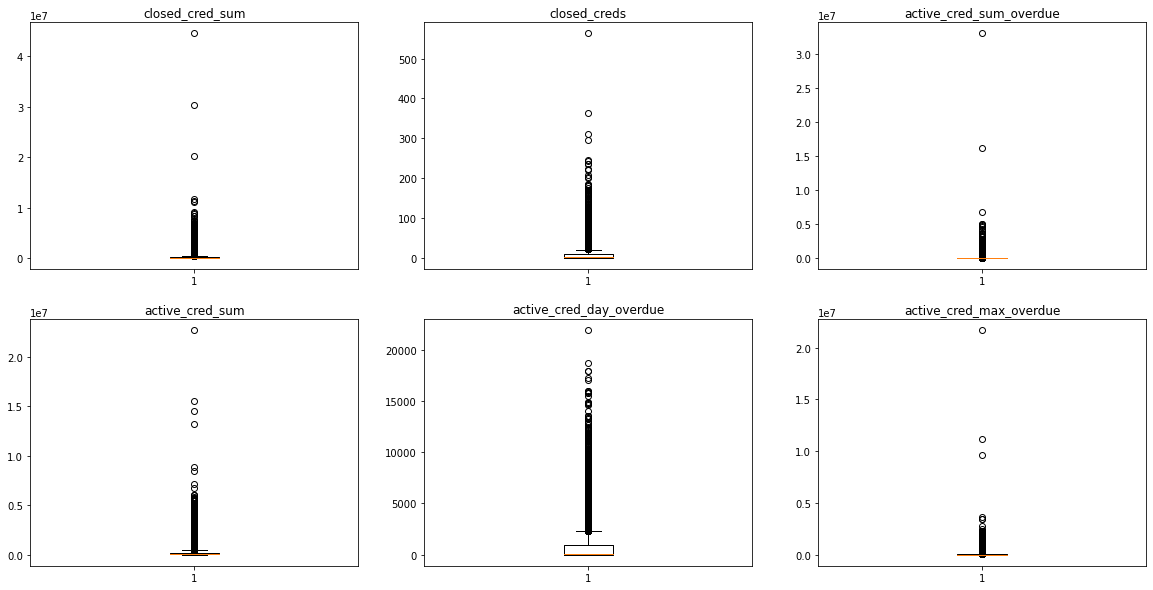

In [30]:
## Построим графики boxplot Для первых 6 признаков
boxplot(data,['closed_cred_sum','closed_creds','active_cred_sum_overdue','active_cred_sum',
                        'active_cred_day_overdue','active_cred_max_overdue'],2,3)

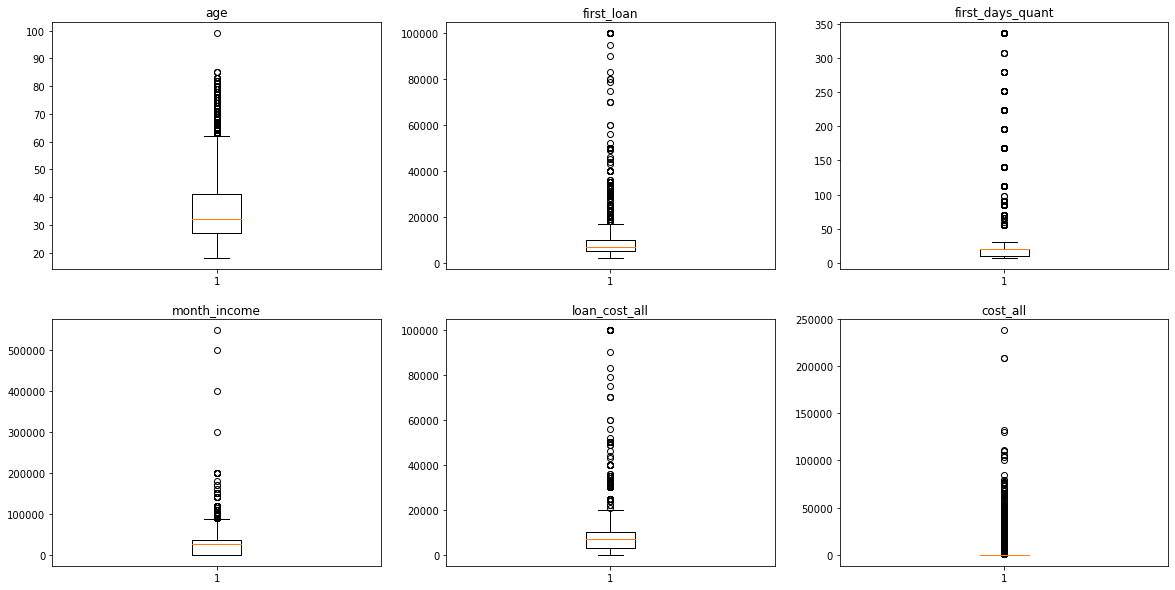

In [31]:
## Теперь построим для оставшихся
boxplot(data,['age','first_loan','first_days_quant','month_income','loan_cost_all','cost_all'],2,3)

На всех графиках видим, что распределение далеко от нормального, практически у всех признаков большая дисперсия, а также наблюдаются выбросы

In [32]:
## Посмторим основные статистические данные
data.describe()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,order_id,client_id,expert
count,4.284000e+04,42840.000000,4.284000e+04,4.284000e+04,42840.00000,4.284000e+04,42840.000000,42840.000000,42840.000000,42840.000000,42840.000000,42840.000000,42840.000000,42840.000000,42840.000000,42840.000000,42840.000000
mean,1.796340e+05,7.817530,4.973543e+04,1.885019e+05,703.04211,3.643237e+04,35.011788,0.458987,28.433754,7725.842670,6632.355275,24.158147,25515.545763,1308.487423,731687.918651,285295.464706,0.261601
std,5.099339e+05,13.947338,2.471866e+05,4.247064e+05,1339.38624,1.693824e+05,11.333374,0.498321,29.713931,5463.964229,4698.822292,37.723358,20532.932480,4693.128005,24984.564121,76418.839719,0.439512
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,18.000000,0.000000,0.000000,2000.000000,100.000000,7.000000,0.000000,0.000000,695828.000000,109.000000,0.000000
25%,5.000000e+03,1.000000,0.000000e+00,1.350000e+04,0.00000,3.555075e+02,27.000000,0.000000,0.000000,5000.000000,3000.000000,10.000000,0.000000,0.000000,712909.750000,285798.500000,0.000000
50%,3.966417e+04,3.000000,5.000000e+03,5.421730e+04,61.00000,6.427800e+03,32.000000,0.000000,24.000000,7000.000000,7000.000000,20.000000,26000.000000,0.000000,730594.500000,313287.500000,0.000000
75%,1.647455e+05,9.000000,3.038790e+04,1.882242e+05,903.00000,2.345083e+04,41.000000,1.000000,52.000000,10000.000000,10000.000000,20.000000,35000.000000,0.000000,746530.250000,326631.250000,1.000000
max,4.457421e+07,563.000000,3.303100e+07,2.273166e+07,21927.00000,2.170166e+07,99.000000,1.000000,99.000000,100000.000000,100000.000000,336.000000,550000.000000,238770.420000,840692.000000,393528.000000,1.000000


Как и ожидалось у всех признаков большая дисперсия  

In [38]:
## Попробуем избавиться от экстримальных выбросов, в тех признаках, в которых они есть, используя quantile
columns_names = ['closed_cred_sum','closed_creds','active_cred_sum_overdue','active_cred_sum','active_cred_max_overdue']
for column in columns_names:
    data = data[data[column] < data[column].quantile(0.999)]
data = data.reset_index(drop = True)

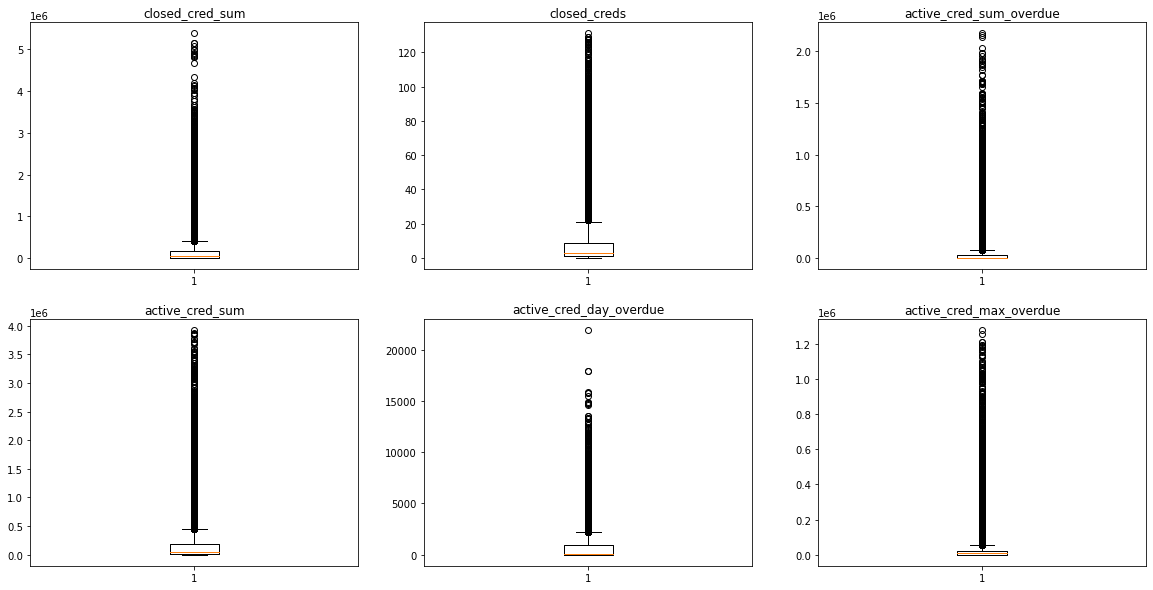

In [41]:
## Еще раз построим графики boxplot
boxplot(data,['closed_cred_sum','closed_creds','active_cred_sum_overdue','active_cred_sum',
                        'active_cred_day_overdue','active_cred_max_overdue'],2,3)

Видим, что экстримальных выбросов стало меньше

In [42]:
## Теперь сгруппируем данные так, чтобы было видно как отличаются значения признаков
## в зависимости от значения целевой переменной
data.groupby('expert').agg({'closed_cred_sum' : 'median','closed_creds' : 'median','active_cred_sum_overdue' : 'median',
                            'active_cred_sum' : 'median','active_cred_day_overdue' : 'median',
                            'active_cred_max_overdue' : 'median','age' : 'median','first_loan' : 'median',
                             'first_days_quant' : 'median','month_income' : 'median', 'loan_cost_all' : 'median',
                            'cost_all' : 'median'})

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,first_loan,first_days_quant,month_income,loan_cost_all,cost_all
expert,,,,,,,,,,,,
0,28525.0,3,8887.84,46962.545,185,9000.00,31,7000.0,18,20000.0,7000,0.0
1,91002.0,7,0.00,83000.000,0,2497.27,37,6000.0,20,35000.0,3000,2959.2


Здесь используем медианное значение признаков, а не среднее, так как медиана лучше охарактеризует признаки в случае такого распределения. Среднее можно было бы использовать, если распределение нормальное (или билзкое к нему)  
  
Посмотрим результаты группировки:
1. Closed_cred_sum (сумма выплаченных клиентом ранее полученных кредитов) - чем больше клиент оплачивал раньше кредиты, тем больше к нему доверия. Но конечно же клиент мог брать кредиты на сумму, гораздо превышающуюю его выплаты, поэтому строго судить логично ли такое соотношение нельзя. Но целевая переменная наверняка значимо зависит от данного признака.
2. closed_creds (количество закрытых кредитов) - здесь логика примерно такая же как и с предыдущим признаком
3. active_cred_sum_overdue (суммарная задолженность по активным кредитам) - здесь логично, у клиентов, которым отказали медианная задолжность выше
4. active_cred_sum (сумма активных кредитов) - здесь труднее судить логичны данные значения или нет, и также о значимости данного признака
5. active_cred_day_overdue (суммарная просрочка в днях по выплатам) - логично, что у клиентов, которым отказали просрочка больше
6. active_cred_max_overdue (максимальная сумма просрочки) - здесь все также логично
7. age (возраст) - видим, что чаще одобряли выдачу кредита, более взрослым клиентам.
8. first_loan (желаеммая сумма кредита) - значения схожи, так что судить о значимости признака трудно, но в целом скорее чаще кредиты одобряют при меньшей запрашиваемой сумме
9. first_days_quant (срок выдачи кредита - желаемый) - здесь также трудно интерпретировать как и с предыдущим признаком
10. cost_all (сумма всех выплат по одобренному кредиту) - данный признак равен 0, если кредит не одобрен

In [43]:
## мы не рассмотрели признак loan_cost_all(одобренная сумма кредита)
## на самом деле он совпадает с признаком first_loan(желаеммая сумма) в случае отказа
## увидим, что совпадение 99,7%
data[data.loan_cost_all == data.first_loan].groupby('expert')['client_id'].count()[0]/data.groupby('expert')['client_id'].count()[0]

0.9972056395274991

In [44]:
## Сгруппируем данные по полу
data.groupby(['expert','gender'])['client_id'].count()

expert  gender
0       0         16750
        1         14742
1       0          6293
        1          4838
Name: client_id, dtype: int64

Видим, что от пола клиента не сильно зависит решение по выдачи кредита

<AxesSubplot:>

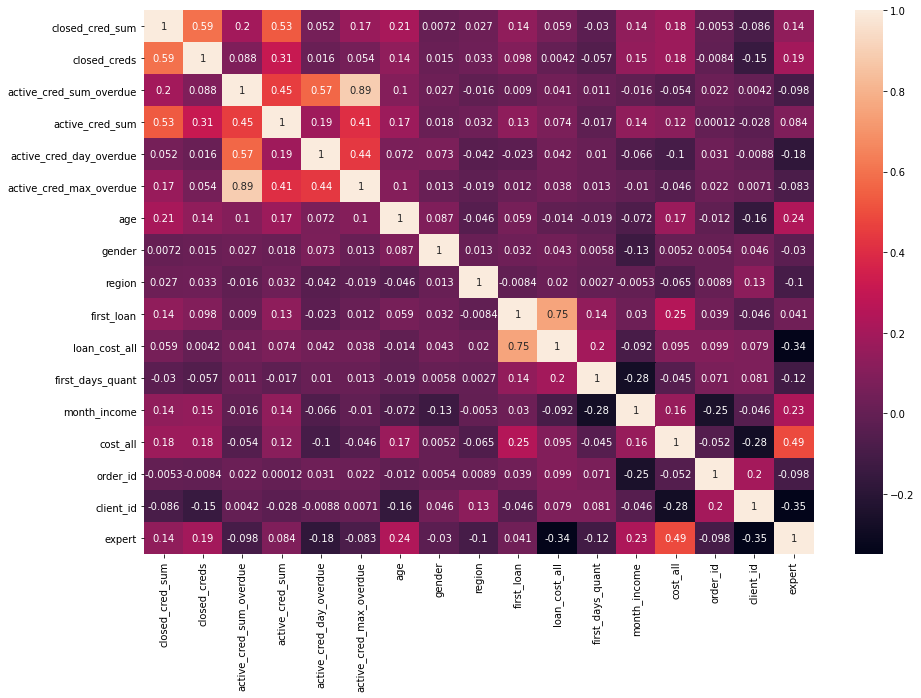

In [45]:
## Теперь построим матрицу корреляций
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), 
        xticklabels=data.corr().columns,
        yticklabels=data.corr().columns, annot =True)

С целевой переменной сильнее коррелируют переменные: 
1. client_id - трудно сказать почему
2. cost_all - как и ожидалось
3. loan_cost_all - тоже вполне ожидаемо
4. Чуть меньше коррелируют month_income, age, что вполне возможно
Но большинство переменных очень слабо коррелируют с целевой, может быть конечно они не имеют значимого влияния на целевую переменную, но скорее их зависимость не линейна  
  
Сильно коррелирующие между сосбой признаки:
1. loan_cost_all и first_loan - как мы и выяснили до этого
2. active_cred_sum_overdure и active_cred_max_overdure - логично, что у некотрых клиентов сумма текущей задолженности может совпадать с максимальной суммой задолженности

Учитывая распределение прзнаков и слабую корреляционную связь признаков с целевой переменной можно предположить, что линейные модели будут хуже предсказывать целевую переменную, в отличие от более сложных

In [71]:
## Заведем список с именами числовых признаков
numeric_names = ['closed_cred_sum','closed_creds','active_cred_sum_overdue','active_cred_sum','active_cred_day_overdue',
                       'active_cred_max_overdue','first_loan','first_days_quant','month_income','age']

В данный список не попадают такие признаки как:  
1. gender(пол) - так как он принимает только два значения (0,1), соответственно его не нужно стандартизировать и на его распределение смотреть также нет смысла
2. region - признак хоть и принимает численные значения, но его стоит рассматривать как категориальный
3. loan_cost_all и cost_all - не стоит использовать данные признаки для прогнозирования, так как они слишком взаимосвязанны с целевой переменной
4. overdate - дату использовать также не стоит, потому что данные предсталены всего за 4 месяца 2017 года и зависимость от даты будет ухудшать качество модели
5. client_id, order_id - нет смысла использовать для предсказания номер заявки и номер клиента, так как в новых данных эти значения скорее всего будут тоже новые
6. expert - целевая переменная

In [47]:
## Теперь заведем список признаков, которые мы исключим при построении модели
drop_columns = ['loan_cost_all','order_date','cost_all','order_id','client_id','expert']

In [72]:
## Создадим функцию для стандартизации числовых признаков
def scaler(df,columns):
    scale = preprocessing.StandardScaler()
    df_scale = scale.fit_transform(df[columns])
    df_scale = pd.DataFrame(df_scale,columns = columns)
    df_result = pd.concat([df_scale,df.drop(columns = columns)],axis = 1)
    return df_result

In [73]:
## Проведём стандартизацию числовых признаков
from sklearn import preprocessing
df_scale = scaler(data,numeric_names)
df_scale = df_scale.reset_index(drop = True)

In [74]:
## Теперь разделим данные: X - матрица признаков, y - вектор значений
X = df_scale.drop(columns = drop_columns)
y = df_scale.expert

In [75]:
## Посмотрим на матрицу X
X.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,first_loan,first_days_quant,month_income,age,gender,region
0,-0.261183,-0.373153,0.980723,0.088251,2.462574,0.482980,-1.053171,-0.375101,1.202398,-0.616162,0,0
1,-0.400572,-0.291253,-0.266334,-0.499144,-0.126395,-0.317888,4.296970,2.323177,1.692197,0.531154,1,46
2,-0.453070,-0.536954,-0.045111,-0.330319,1.510714,-0.243135,-0.684196,-0.269286,0.467700,0.531154,1,0
3,-0.128241,-0.291253,0.383861,-0.017335,3.176852,0.291866,-0.130733,-0.322194,1.202398,0.354644,1,0
4,-0.470098,-0.618854,-0.102452,-0.435938,0.390788,-0.019742,0.422730,-0.375101,0.467700,-1.057437,1,32


In [76]:
## Посмотрим на метки классов y
y.head()

0    0
1    0
2    0
3    0
4    0
Name: expert, dtype: int64

In [77]:
## Оценим баланс классов 
y[y == 1].shape[0]/y.shape[0]

0.2611500832883654

Видим, что классы не сбалансированны, значит для построения моделей придется делать балансировку классов  
Также отсюда понимаем, что для оценки моделей лучше использовать метрики roc_auc_score, которая характеризует взаимосвязь fpr и tpr при разных порогах разделения меток классов, также f1_score (Ф-мера), которая характеризует взаимосвязь метрик precision (точность) и recall (полнота). При несбалансированных классах лучше использовать данные метрики в отличии от accuracy (доля правильных ответов), так как если к примеру взять наши данные и сделать предсказание таким образом, что все метки будут иметь класс 0, то доля правильных ответов будет 73.9%, что совершенно не говорит о точности нашей модели

In [78]:
## Создадим функцию для вычисления roc_auc_score
def auc_score(X_train,y_train,X_test,y_test,estimator):
    print ('train_dataset_roc_auc_score',metrics.roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1]),'\n')
    print ('test_dataset_roc_auc_score',metrics.roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1]),'\n')

In [79]:
## Создадим функцию для вычисления f1_score
def f1_score(X_train,y_train,X_test,y_test,estimator):
    print ('train_dataset_f1_score',metrics.f1_score(y_train,estimator.predict(X_train)),'\n')
    print ('test_dataset_f1_score',metrics.f1_score(y_test,estimator.predict(X_test)),'\n')

In [80]:
## Разобъем наши данные на тренировочную и тестовую выборки
## Для начала попробуем разбить данные таким образом, чтобы в тесте были более позднии данные, так как предсказывать целевую
## переменную нам придется по данным будующих месяцев
## Возьмём для теста 10000 последних объектов (данные мы отсортировали в самом начале)
X_train = X[:-10000]
X_test = X[-10000:]
y_train = y[:-10000]
y_test = y[-10000:]

In [81]:
## Посмотрим на размер наших выборок
print (X_train.shape)
print (X_test.shape)

(32623, 12)
(10000, 12)


In [82]:
## Теперь попробуем постороить первые модели
## Для сравнения будем использовать Логистическую регрессию, Случайный лес и Градиентный бустинг
log_reg = linear_model.LogisticRegression(random_state = 0, class_weight = 'balanced', max_iter = 200)
rf_clf = ensemble.RandomForestClassifier(random_state = 0, class_weight = 'balanced')
gb_clf = ensemble.GradientBoostingClassifier(random_state = 0)

In [83]:
## Обучим логистическую регрессию регрессию
log_reg = log_reg.fit(X_train,y_train)

In [84]:
## Обучим RandomForestClassifier
rf_clf = rf_clf.fit(X_train,y_train)

In [85]:
## Обучим GeadientBoostingClassifier
gb_clf = gb_clf.fit(X_train,y_train)

In [70]:
## Посмотрим на точность моделей по очереди по двум метрикам
print ('Логистическая регрессия\n')
auc_score(X_train,y_train,X_test,y_test,log_reg)
f1_score(X_train,y_train,X_test,y_test,log_reg)
print ('Случайный лес\n')
auc_score(X_train,y_train,X_test,y_test,rf_clf)
f1_score(X_train,y_train,X_test,y_test,rf_clf)
print ('Градиентный бустинг\n')
auc_score(X_train,y_train,X_test,y_test,gb_clf)
f1_score(X_train,y_train,X_test,y_test,gb_clf)

Логистическая регрессия

train_dataset_roc_auc_score 0.7797787895471602 

test_dataset_roc_auc_score 0.8116414774128493 

train_dataset_f1_score 0.571352146582854 

test_dataset_f1_score 0.5533776688834442 

Случайный лес

train_dataset_roc_auc_score 0.9999982000031068 

test_dataset_roc_auc_score 0.92899481816895 

train_dataset_f1_score 0.9996083916083915 

test_dataset_f1_score 0.7163280662151995 

Градиентный бустинг

train_dataset_roc_auc_score 0.9299103225484828 

test_dataset_roc_auc_score 0.9317833466369171 

train_dataset_f1_score 0.730757264638168 

test_dataset_f1_score 0.7041825095057035 



Как и ожидалось логистическая регрессия сработала хуже чем сложные модели  
Модель Случайного леса как-будто переобучилась, ошибка на тесте особенно для Ф-меры выглядит сильно больше чем на обучении

In [87]:
## До этого мы использовали признак region как числовой
## Для моделей RandomForest и GradientBoosting это не должно значительно влиять на качество, но для линейных моделей влияет
## Поэтому проведем бинаризацию данных для признака region
df_one_hot = pd.get_dummies(df_scale,columns = ['region'], sparse = False)

In [88]:
## Теперь снова разделим данные
X_one_hot = df_one_hot.drop(columns = drop_columns)
y_one_hot = df_one_hot.expert

In [89]:
## Снова разобьем данные на обучение и тест
X_train = X_one_hot[:-10000]
X_test = X_one_hot[-10000:]
y_train = y_one_hot[:-10000]
y_test = y_one_hot[-10000:]

In [90]:
## Обучим снова все модели
log_reg = log_reg.fit(X_train,y_train)
rf_clf = rf_clf.fit(X_train,y_train)
gb_clf = gb_clf.fit(X_train,y_train)

C:\Users\n.dubrovnyj\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
## Снова посмотрим на точность моделей по очереди по двум метрикам
print ('Логистическая регрессия\n')
auc_score(X_train,y_train,X_test,y_test,log_reg)
f1_score(X_train,y_train,X_test,y_test,log_reg)
print ('Случайный лес\n')
auc_score(X_train,y_train,X_test,y_test,rf_clf)
f1_score(X_train,y_train,X_test,y_test,rf_clf)
print ('Градиентный бустинг\n')
auc_score(X_train,y_train,X_test,y_test,gb_clf)
f1_score(X_train,y_train,X_test,y_test,gb_clf)

Логистическая регрессия

train_dataset_roc_auc_score 0.8197388197893756 

test_dataset_roc_auc_score 0.8420438098934887 

train_dataset_f1_score 0.616239663819981 

test_dataset_f1_score 0.5960072595281307 

Случайный лес

train_dataset_roc_auc_score 0.9999978409486084 

test_dataset_roc_auc_score 0.9282976422741687 

train_dataset_f1_score 0.9996083916083915 

test_dataset_f1_score 0.7078708375378405 

Градиентный бустинг

train_dataset_roc_auc_score 0.929146691583033 

test_dataset_roc_auc_score 0.9317660398173591 

train_dataset_f1_score 0.7270238317466244 

test_dataset_f1_score 0.7047234150037889 



Как и предполагали качество Логистической регрессии улучшилось, а на нелинейные модели бинаризация категориального признака никак не повлияла, поэтому как базовую модель будем использовать модель GradientBoostingClassifier  
Также заметим что в некоторых случаях качество на тесте лучше качества на обучении, поэтому в дальнейшем для оценки качества будем использовать кросс валидацию.  
  
  Теперь еще попробуем проанализировать наши данные

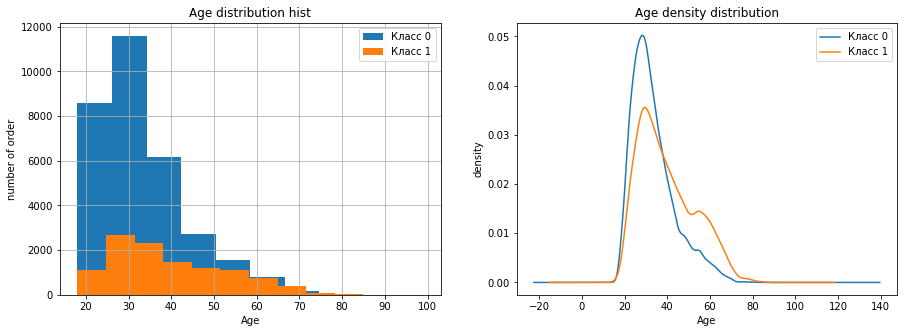

In [124]:
## Построим распределение заявок по возрасту клиентов, для разных классов
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
data.groupby('expert').age.hist()
plt.title("Age distribution hist")
plt.xlabel("Age")
plt.ylabel("number of order")
plt.legend(['Класс 0', 'Класс 1'])
plt.subplot(1,2,2)
data.groupby('expert').age.plot(kind = 'kde')
plt.title("Age density distribution")
plt.xlabel("Age")
plt.ylabel("density")
plt.legend(['Класс 0', 'Класс 1'])

По графикам видим, что наибольшее количество заявок, как для класса 1 так и для класса 0, совершали клиенты в возрасте около 30 лет.  
Также видим, что клиентам в возрасте старше 65, чаще одобряле кредит, чем не одобряли

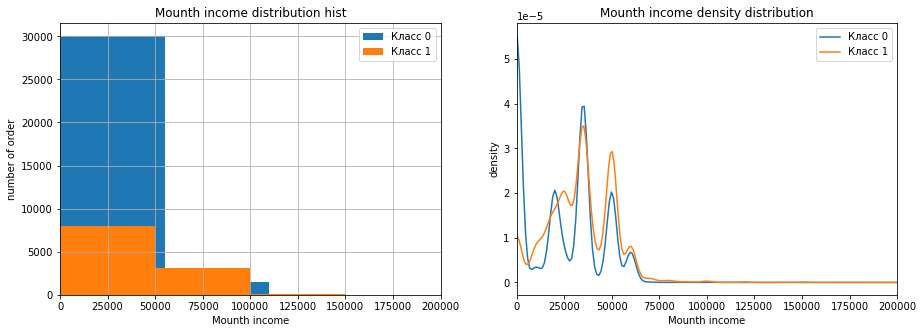

In [131]:
## Построим распределение заявок по месячному доходу клиентов, для разных классов
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
data.groupby('expert').month_income.hist()
plt.title("Mounth income distribution hist")
plt.xlabel("Mounth income")
plt.ylabel("number of order")
plt.xlim(0,200000)
plt.legend(['Класс 0', 'Класс 1'])
plt.subplot(1,2,2)
data.groupby('expert').month_income.plot(kind = 'kde')
plt.title("Mounth income density distribution")
plt.xlabel("Mounth income")
plt.ylabel("density")
plt.xlim(0,200000)
plt.legend(['Класс 0', 'Класс 1'])

Как мы и видели раньше распределение данного признака не "нормальное"  
У клиентов с доходом выше примерно 110 тыс. только положительные решения по кредиту.

In [140]:
## Посмотрим теперь на значимость признаков используя модель Градиентного бустинга
## Сначала добавим признак region к числовым признакам и обучим GradientBoostingClassifier на всех данных
numeric_names = ['closed_cred_sum','closed_creds','active_cred_sum_overdue','active_cred_sum','active_cred_day_overdue',
                       'active_cred_max_overdue','first_loan','first_days_quant','month_income','age','region']
from sklearn import preprocessing
df_scale = scaler(data,numeric_names)
df_scale = df_scale.reset_index(drop = True)
X = df_scale.drop(columns = drop_columns)
y = df_scale.expert
gb_clf = gb_clf.fit(X,y)

In [141]:
## Посмотрим значимость признаков
gb_clf.feature_importances_

array([0.0104119 , 0.11955366, 0.11916625, 0.01788528, 0.07784789,
       0.00536943, 0.15037517, 0.16225681, 0.20770787, 0.07350953,
       0.05591622, 0.        ])

In [144]:
## Создадим DataFrame для значимости признаков
df_feature_importance = pd.DataFrame(data = np.vstack((X.columns.values,gb_clf.feature_importances_)).transpose(),
             columns =['feature_name','feature_importance'])
df_feature_importance

,feature_name,feature_importance
0,closed_cred_sum,0.0104119
1,closed_creds,0.119554
2,active_cred_sum_overdue,0.119166
3,active_cred_sum,0.0178853
4,active_cred_day_overdue,0.0778479
5,active_cred_max_overdue,0.00536943
6,first_loan,0.150375
7,first_days_quant,0.162257
8,month_income,0.207708
9,age,0.0735095


In [148]:
## Теперь отсортируем признаки по их значимости
df_feature_imporance = df_feature_importance.sort_values(by = 'feature_importance', ascending=False).reset_index(drop = True)
df_feature_imporance

,feature_name,feature_importance
0,month_income,0.207708
1,first_days_quant,0.162257
2,first_loan,0.150375
3,closed_creds,0.119554
4,active_cred_sum_overdue,0.119166
5,active_cred_day_overdue,0.0778479
6,age,0.0735095
7,region,0.0559162
8,active_cred_sum,0.0178853
9,closed_cred_sum,0.0104119


Видим, что наиболее значимыми признаками являются: Месячный доход, желаемый срок кредита, желаемая сумма кредита, количество закрытых кредитов и сумма активной задолженности  
  
Наименее значимые: пол, максимальная сумма задолженности, сумма закрытых кредитов.

In [149]:
## Теперь попробуем сравнить качество модели со всеми признаками и модели без признака gender
## Сначала оценим качество модели со всеми признаками на кросс валидации
gb_clf = ensemble.GradientBoostingClassifier(random_state = 0)
model_selection.cross_val_score(gb_clf,X,y,scoring = 'roc_auc', cv =7).mean()

0.9265388257326254

In [155]:
## Без признака gender
model_selection.cross_val_score(gb_clf,X[df_feature_imporance[0:11].feature_name.values],y,scoring = 'roc_auc', cv =7).mean()

0.9265199528964839

In [156]:
## Видим, что качество не сильно пострадало, попробуем убрать еще один признак
model_selection.cross_val_score(gb_clf,X[df_feature_imporance[0:10].feature_name.values],y,scoring = 'roc_auc', cv =7).mean()

0.9260136924766177

In [157]:
## Повторим процедуру
model_selection.cross_val_score(gb_clf,X[df_feature_imporance[0:9].feature_name.values],y,scoring = 'roc_auc', cv =7).mean()

0.9256341265462515

In [158]:
model_selection.cross_val_score(gb_clf,X[df_feature_imporance[0:8].feature_name.values],y,scoring = 'roc_auc', cv =7).mean()

0.9222622851465634

In [159]:
## Здесь качество модели начинает меняться существеннее
model_selection.cross_val_score(gb_clf,X[df_feature_imporance[0:7].feature_name.values],y,scoring = 'roc_auc', cv =7).mean()

0.9162659918513796

Видим, что если убрать 5 признаков, то кчество моедли по roc_auc_score снизится на 1%, поэтому остановимся на 8 признаках, чтобы попробовать настроить модель  
  
Для настройки модели будем измерять ее качество изменняя разные признаки по очереди  
Можно использовать GridSearchCV, но работа с сеткой занимает слишком много времени

In [161]:
## Создатим новую матрицу X_import_features
X_import_features = X[df_feature_imporance[0:8].feature_name.values]

In [160]:
## Посмотрим на параметры GradientBoostingClassifier
gb_clf.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

Для настройки попробуем подобрать следующие параметры:
1. n_estimators - количество используемых деревьев
2. max_depth - максимальная глубина дерева
3. min_samples_split - минимальное количество образцов для разделения листа дерева
4. min_samples_leaf - минимальное количество образцов находящихся в листе дерева  
  
Для оценки качества возьмем roc_auc_score

In [164]:
## Разобьем данные на обучающую и тестовую выборки, чтобы проверять качество на обучении и на тесте,
## также отрезая последние 10000 образцов для теста 
X_train = X_import_features[:-10000]
X_test = X_import_features[-10000:]
y_train = y[:-10000]
y_test = y[-10000:]

In [166]:
## Сначала протестируем модель при разных парметрах min_samples_leaf
n_sample_leaf = [1,2,4,8]
train_score_leaf = []
test_score_leaf = []
for i in n_sample_leaf:
    gb_clf = ensemble.GradientBoostingClassifier(min_samples_leaf = i)
    gb_clf = gb_clf.fit(X_train,y_train)
    train_score_leaf.append(metrics.roc_auc_score(y_train,gb_clf.predict_proba(X_train)[:,1]))
    test_score_leaf.append(metrics.roc_auc_score(y_test,gb_clf.predict_proba(X_test)[:,1]))
    print (i)
train_score_leaf = np.array(train_score_leaf)
test_score_leaf = np.array(test_score_leaf)

1
2
4
8


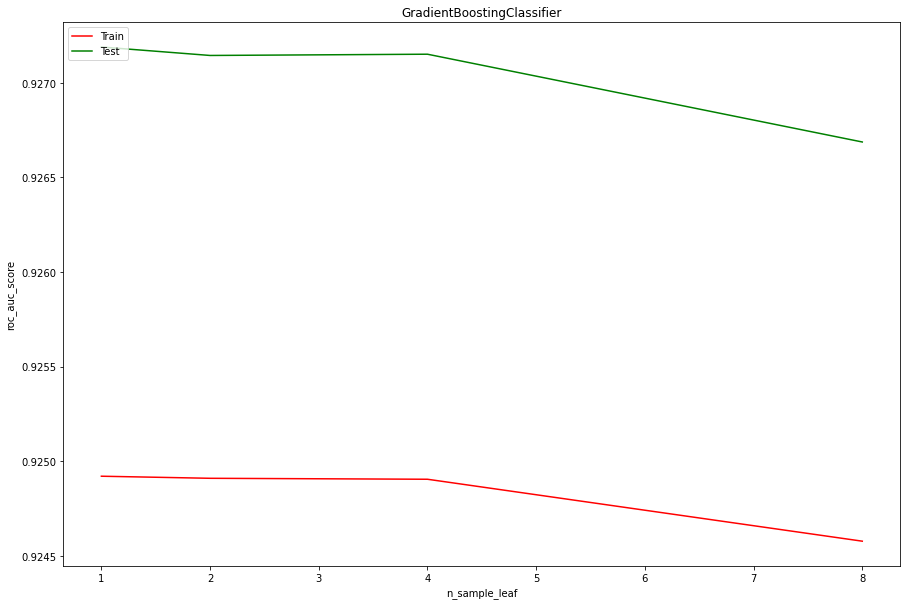

In [167]:
## Построим график качества модели в зависимости от параметра min_samples_leaf
plt.figure(figsize = (15,10))
plt.plot(n_sample_leaf,train_score_leaf,'r-',n_sample_leaf,test_score_leaf,'g-')
plt.title('GradientBoostingClassifier')
plt.xlabel('n_sample_leaf')
plt.ylabel('roc_auc_score')
plt.legend(['Train','Test'], loc=2)

Видим, что качество модели начинает падать при количестве образцов в каждом листе больше 4  
  
Вывод значений парметра мне нужен, чтобы отслеживать на каком этапе находится обучение

In [174]:
## Протестируем модель при разных значениях парметра min_samples_split
n_sample_split = [20,50,80,100]
train_score_split = []
test_score_split = []
for i in n_sample_split:
    gb_clf = ensemble.GradientBoostingClassifier(min_samples_split = i)
    gb_clf = gb_clf.fit(X_train,y_train)
    train_score_split.append(metrics.roc_auc_score(y_train,gb_clf.predict_proba(X_train)[:,1]))
    test_score_split.append(metrics.roc_auc_score(y_test,gb_clf.predict_proba(X_test)[:,1]))
    print (i)
train_score_split = np.array(train_score_split)
test_score_split = np.array(test_score_split)

20
50
80
100


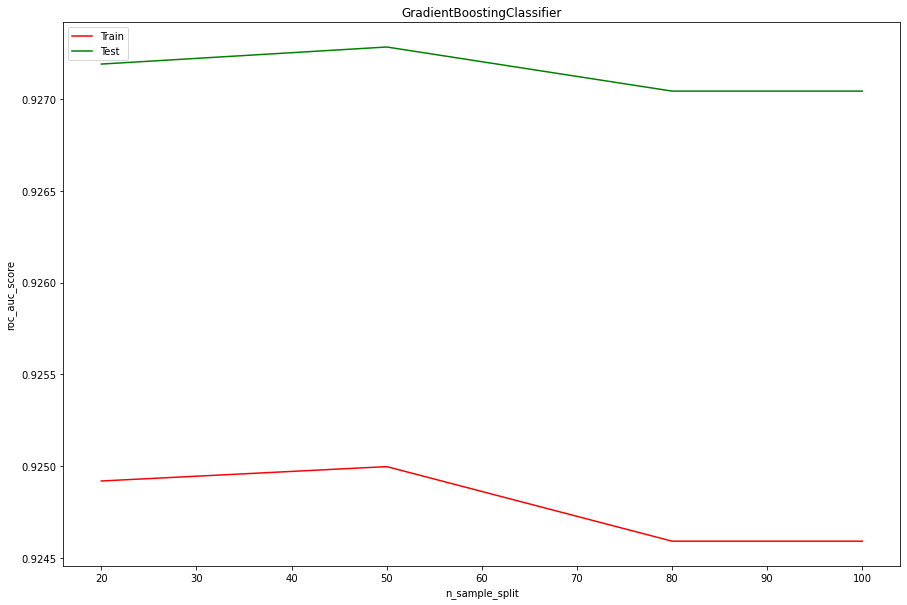

In [175]:
## Построим график качества модели в зависимости от параметра min_samples_split
plt.figure(figsize = (15,10))
plt.plot(n_sample_split,train_score_split,'r-',n_sample_split,test_score_split,'g-')
plt.title('GradientBoostingClassifier')
plt.xlabel('n_sample_split')
plt.ylabel('roc_auc_score')
plt.legend(['Train','Test'], loc=2)

Лучшее качество достигается при минимальном количистве объектов необходимых для разбиения равным 50

In [179]:
## Протестируем модель при разных значениях парметра max_depth,
## но уже будем использовать предыдущие параметры, для более быстрой работы модели
n_depth = [2,4,6,10]
train_score_depth = []
test_score_depth = []
for i in n_depth:
    gb_clf = ensemble.GradientBoostingClassifier(min_samples_split = 50, min_samples_leaf = 4, max_depth = i)
    gb_clf = gb_clf.fit(X_train,y_train)
    train_score_depth.append(metrics.roc_auc_score(y_train,gb_clf.predict_proba(X_train)[:,1]))
    test_score_depth.append(metrics.roc_auc_score(y_test,gb_clf.predict_proba(X_test)[:,1]))
    print (i)
train_score_depth = np.array(train_score_depth)
test_score_depth = np.array(test_score_depth)

2
4
6
10


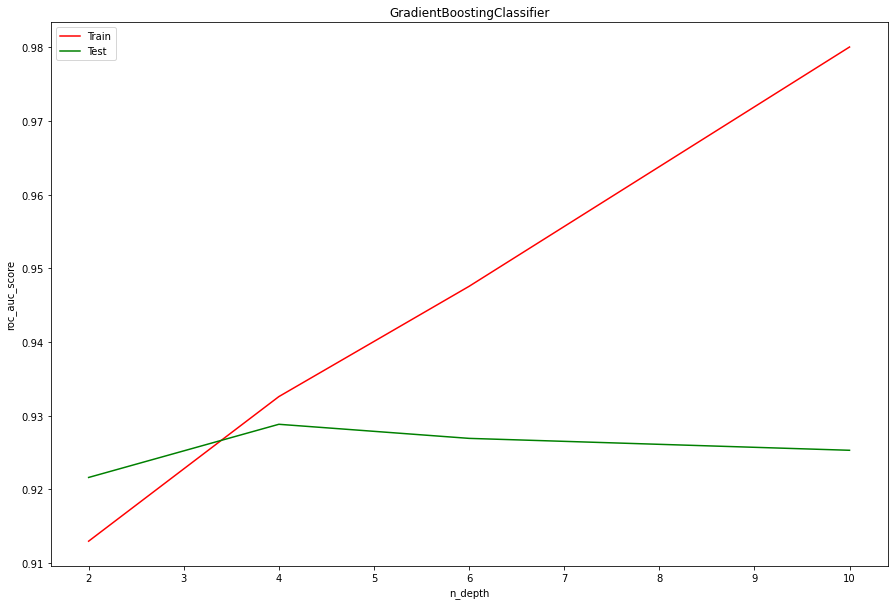

In [180]:
## Построим график качества модели в зависимости от параметра max_depth
plt.figure(figsize = (15,10))
plt.plot(n_depth,train_score_depth,'r-',n_depth,test_score_depth,'g-')
plt.title('GradientBoostingClassifier')
plt.xlabel('n_depth')
plt.ylabel('roc_auc_score')
plt.legend(['Train','Test'], loc=2)

Лучшее качество модели на тесте при глубине 4, дальше заметно переобучение

In [185]:
## Протестируем модель при разных значениях парметра n_estimators
n_estimators = [100,200,300,500]
train_score_estimators = []
test_score_estimators = []
for i in n_estimators:
    gb_clf = ensemble.GradientBoostingClassifier( n_estimators = i)
    gb_clf = gb_clf.fit(X_train,y_train)
    train_score_estimators.append(metrics.roc_auc_score(y_train,gb_clf.predict_proba(X_train)[:,1]))
    test_score_estimators.append(metrics.roc_auc_score(y_test,gb_clf.predict_proba(X_test)[:,1]))
    print (i)
train_score_estimators = np.array(train_score_estimators)
test_score_estimators = np.array(test_score_estimators)

100
200
300
500


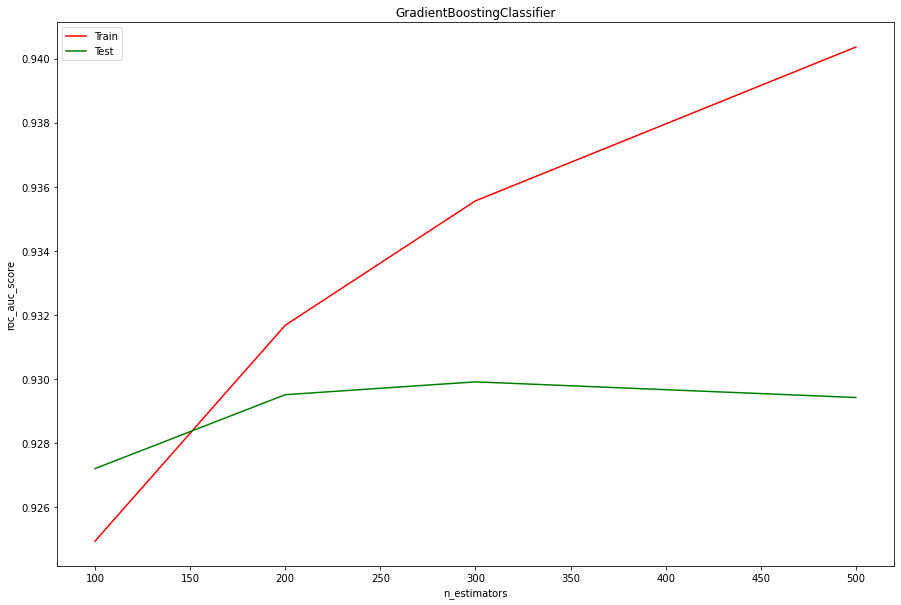

In [187]:
## Построим график качества модели в зависимости от параметра n_estimators
plt.figure(figsize = (15,10))
plt.plot(n_estimators,train_score_estimators,'r-',n_estimators,test_score_estimators,'g-')
plt.title('GradientBoostingClassifier')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')
plt.legend(['Train','Test'], loc=2)

Видим лучшее качество модели при количестве деревьев 300

In [188]:
## Снова проверим параметр глубины дерева
n_depth = [2,4,6,10]
train_score_depth = []
test_score_depth = []
for i in n_depth:
    gb_clf = ensemble.GradientBoostingClassifier(min_samples_split = 50, min_samples_leaf = 4, max_depth = i, n_estimators = 300)
    gb_clf = gb_clf.fit(X_train,y_train)
    train_score_depth.append(metrics.roc_auc_score(y_train,gb_clf.predict_proba(X_train)[:,1]))
    test_score_depth.append(metrics.roc_auc_score(y_test,gb_clf.predict_proba(X_test)[:,1]))
    print (i)
train_score_depth = np.array(train_score_depth)
test_score_depth = np.array(test_score_depth)

2
4
6
10


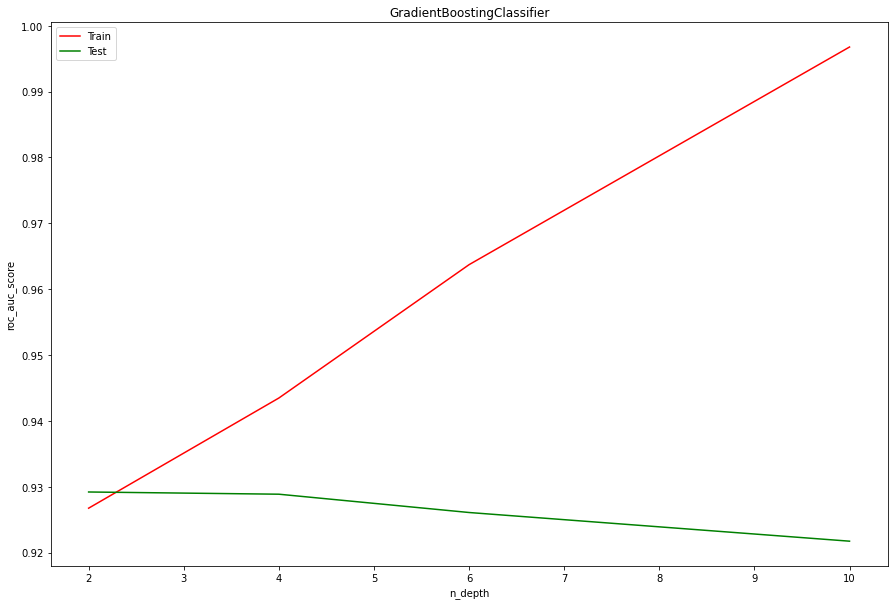

In [189]:
## Построим график качества модели в зависимости от параметра max_depth
plt.figure(figsize = (15,10))
plt.plot(n_depth,train_score_depth,'r-',n_depth,test_score_depth,'g-')
plt.title('GradientBoostingClassifier')
plt.xlabel('n_depth')
plt.ylabel('roc_auc_score')
plt.legend(['Train','Test'], loc=2)

Видим, что теперь качество лучше при глубине дерева 2

In [193]:
## Снова тестируем модель в зависимотсти от min_samples_split
n_sample_split = [50,100, 200]
train_score_split = []
test_score_split = []
for i in n_sample_split:
    gb_clf = ensemble.GradientBoostingClassifier(min_samples_split = i, min_samples_leaf = 4, max_depth = 2, n_estimators = 300)
    gb_clf = gb_clf.fit(X_train,y_train)
    train_score_split.append(metrics.roc_auc_score(y_train,gb_clf.predict_proba(X_train)[:,1]))
    test_score_split.append(metrics.roc_auc_score(y_test,gb_clf.predict_proba(X_test)[:,1]))
    print (i)
train_score_split = np.array(train_score_split)
test_score_split = np.array(test_score_split)

50
100
200


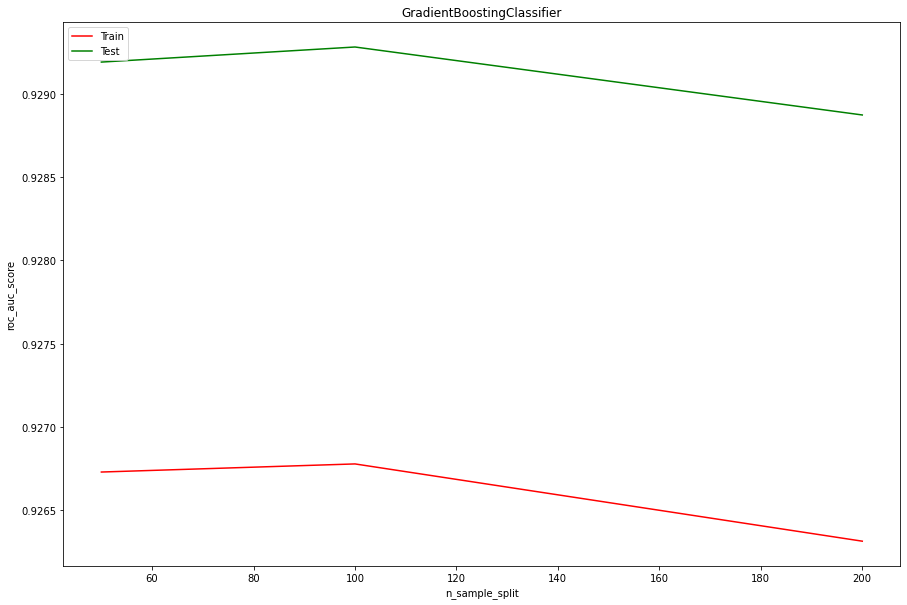

In [194]:
## Построим график качества модели в зависимости от параметра min_samples_split
plt.figure(figsize = (15,10))
plt.plot(n_sample_split,train_score_split,'r-',n_sample_split,test_score_split,'g-')
plt.title('GradientBoostingClassifier')
plt.xlabel('n_sample_split')
plt.ylabel('roc_auc_score')
plt.legend(['Train','Test'], loc=2)

Теперь качество лучше при 100 объектах для разбиения

In [195]:
## Ну еще раз подберем значения для min_samples_leaf
n_sample_leaf = [1,2,4,8]
train_score_leaf = []
test_score_leaf = []
for i in n_sample_leaf:
    gb_clf = ensemble.GradientBoostingClassifier(min_samples_split = 100, min_samples_leaf = i, max_depth = 2, n_estimators = 300)
    gb_clf = gb_clf.fit(X_train,y_train)
    train_score_leaf.append(metrics.roc_auc_score(y_train,gb_clf.predict_proba(X_train)[:,1]))
    test_score_leaf.append(metrics.roc_auc_score(y_test,gb_clf.predict_proba(X_test)[:,1]))
    print (i)
train_score_leaf = np.array(train_score_leaf)
test_score_leaf = np.array(test_score_leaf)

1
2
4
8


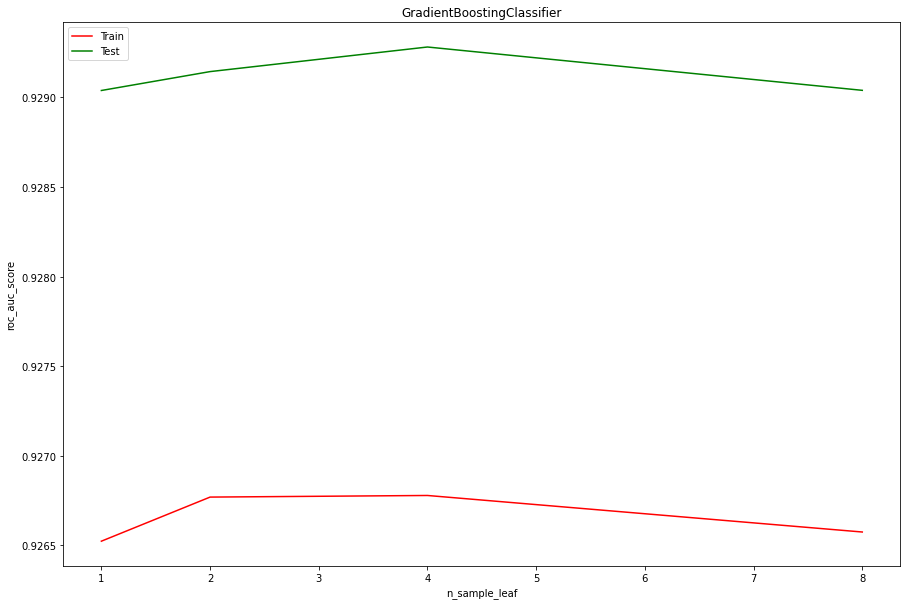

In [196]:
plt.figure(figsize = (15,10))
plt.plot(n_sample_leaf,train_score_leaf,'r-',n_sample_leaf,test_score_leaf,'g-')
plt.title('GradientBoostingClassifier')
plt.xlabel('n_sample_leaf')
plt.ylabel('roc_auc_score')
plt.legend(['Train','Test'], loc=2)

Видим, что здесь ничего не изменилось

In [197]:
## Теперь замерим качество на кросс валидации для 8 признаков и для 12 признаков
gb_clf = ensemble.GradientBoostingClassifier(min_samples_split = 100, min_samples_leaf = 4, max_depth = 2, n_estimators = 300)
model_selection.cross_val_score(gb_clf,X[df_feature_imporance[0:8].feature_name.values],y,scoring = 'roc_auc', cv =7).mean()

0.9246682343208803

In [198]:
model_selection.cross_val_score(gb_clf,X,y,scoring = 'roc_auc', cv =7).mean()

0.9294133011697588

Видим, что качество улучшилось, хоть и не сильно  
Для более качественного подбора параметров необходимо использовать GridSearchCV - это сетка, которая перебирает парметра и сразу сравнивает модели на кросс валидации тем самым подбирая лучшую модель, но как я говорил, требует слишком много времени для обучения модели

In [200]:
## Теперь подберем порог, по которому разбиваются классы на 0 и 1, по умолчанию он равен 0.5, 
## то есть если вероятность принадлежности 1 классу больше 0.5, то модель помечает 1 класс для объекта, наоборот 0 класс.
## Для начала снова обучим нашу модель
gb_clf = gb_clf.fit(X,y)

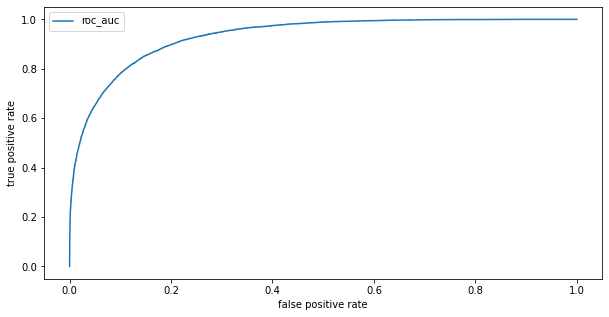

In [202]:
## Построим ROC кривую
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = metrics.roc_curve(y,gb_clf.predict_proba(X)[:,1])
plt.plot(fpr, tpr)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(['roc_auc'], loc=2)

In [203]:
## Найдем наилучший порог
dist_list = []
for i,j in zip(fpr,tpr):
    dist_list.append(math.sqrt((0-i)**2+(1-j)**2))
T = thresholds[dist_list.index((min(dist_list)))]
print (T)

0.27654171828256807


Видим, что наилучший порог для разбиения 0,276, значит при вероятности принадлежности объекта к 1 классу более этого значения, стоит относить объект к 1 классу  
  
Теперь снова разобьем выборку на обучение и тест и сравнм значение Ф-меры при разных порогах

In [204]:
## Делим данные на 2 выборки
X_train = X[:-10000]
X_test = X[-10000:]
y_train = y[:-10000]
y_test = y[-10000:]

In [205]:
## Обучим заново нашу модель
gb_clf = ensemble.GradientBoostingClassifier(min_samples_split = 100, min_samples_leaf = 4, max_depth = 2, n_estimators = 300)
gb_clf = gb_clf.fit(X_train,y_train)

In [210]:
## Сначала замерим значения Ф-меры при пороге по умолчанию
print ('Значения Ф-меры с порогом по умолчанию\n')
f1_score(X_train,y_train,X_test,y_test,gb_clf)

Значения Ф-меры с порогом по умолчанию

train_dataset_f1_score 0.7402256785605368 

test_dataset_f1_score 0.7153539381854437 



In [207]:
## Разобьем метки классов отностиельно нового порога
y_pred = []
for i in gb_clf.predict_proba(X_test)[:,1]:
    if i > T:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred = np.array(y_pred)

In [211]:
## Теперь оценим Ф-меру для нового порога
print ('Значения Ф-меры с порогом T = 0.276\n')
metrics.f1_score(y_test,y_pred)

Значения Ф-меры с порогом T = 0.276



0.7286452125546286

In [213]:
## Также измерим значения точности и полноты
print ('Значения точности и полноты\n')
print (metrics.precision_score(y_test,y_pred))
print (metrics.recall_score(y_test,y_pred))

Значения точности и полноты

0.6460021134202184
0.8355353075170843


Видим, что при изменении порога качество модели улучшилось

После проделанной работы для предсказания целевой переменной выберем:  
1. Модель - GradientBoostingClassifier(min_samples_split = 100, min_samples_leaf = 4, max_depth = 2, n_estimators = 300)
2. Метрики оценки качества ROC_AUC_Score и F1_Score